In [1]:
%load_ext autoreload
%autoreload 2

from text3d2video.pipelines.controlnet_pipeline import ControlNetPipeline
import torch
from diffusers import ControlNetModel

from text3d2video.noise_initialization import FixedNoiseInitializer

device = torch.device('cuda')
dtype = torch.float16

sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"

controlnet = ControlNetModel.from_pretrained(controlnet_repo, torch_dtype=dtype).to(
    device
)

torch.set_grad_enabled(False)

pipe: ControlNetPipeline = ControlNetPipeline.from_pretrained(
    sd_repo, controlnet=controlnet, torch_dtype=dtype
).to(device)

pipe.noise_initializer = FixedNoiseInitializer()

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

/home/jorge/miniconda3/envs/thesis4/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


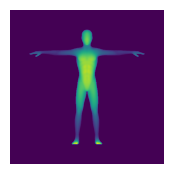

<Figure size 640x480 with 0 Axes>

In [17]:
from text3d2video.artifacts.anim_artifact import AnimationArtifact
from text3d2video.rendering import render_depth_map
from text3d2video.utilities.camera_placement import front_facing_extrinsics
from text3d2video.utilities.ipython_utils import display_ims
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.renderer import FoVOrthographicCameras

from text3d2video.utilities.mesh_processing import normalize_meshes

animation = AnimationArtifact.from_wandb_artifact_tag("handstand:latest")
verts_uvs, faces_uvs = animation.uv_data()

meshes = load_objs_as_meshes(["data/meshes/mixamo-human.obj"]).to(device)
meshes = normalize_meshes(meshes)

R, T = front_facing_extrinsics(zs=1)
s = 1.5

cams = FoVOrthographicCameras(R=R, T=T, device=device, scale_xyz=[(s, s, s)])
meshes = meshes.extend(len(cams))

depth_map = render_depth_map(meshes, cams)[0]

display_ims([depth_map])

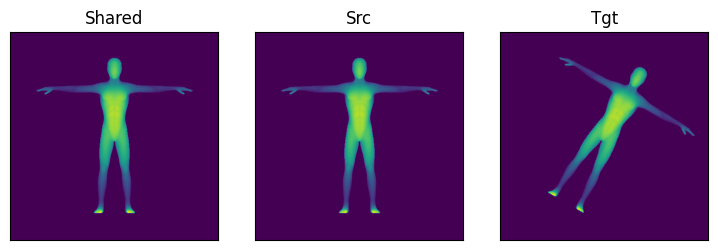

In [31]:
from typing import List
from text3d2video.utilities.image_utils import Affine2D
from text3d2video.utilities.ipython_utils import display_ims_grid
from PIL import Image




def display_2D_warp_input(
    shared_map: Image, source_funs: List[Affine2D], tgt_funs: List[Affine2D]
):
    src_depth_maps = [f(shared_map) for f in source_funs]
    tgt_depth_maps = [f(shared_map) for f in tgt_funs]

    titles = ["Shared"] + ["Src"] * len(src_depth_maps) + ["Tgt"] * len(tgt_depth_maps)
    display_ims_grid(
        [[shared_map] + src_depth_maps + tgt_depth_maps], col_titles=titles
    )

src_transform = Affine2D()
tgt_transforms = [Affine2D(angle=30)]

display_2D_warp_input(depth_map, [src_transform], tgt_transforms)

100%|██████████| 31/31 [00:03<00:00,  9.78it/s]


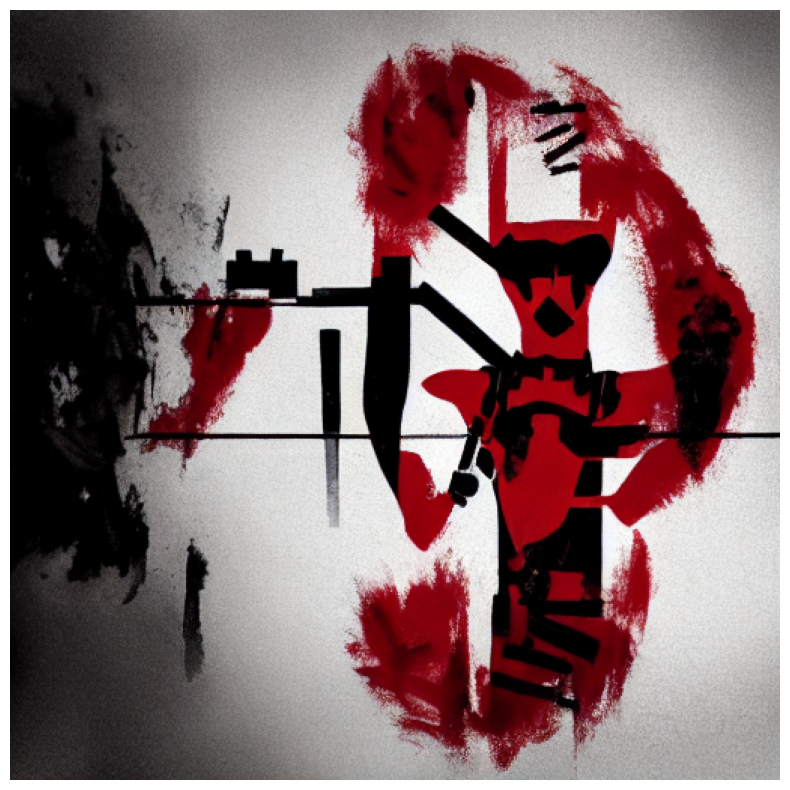

<Figure size 640x480 with 0 Axes>

In [27]:
prompt = "Deadpool"
gen = torch.Generator(device=device)
gen.manual_seed(0)

image = pipe([prompt], [depth_map], generator=gen)[0]

display_ims([image], scale=10)